# Website A/B Testing - Lab

## Introduction

In this lab, you'll get another chance to practice your skills at conducting a full A/B test analysis. It will also be a chance to practice your data exploration and processing skills! The scenario you'll be investigating is data collected from the homepage of a music app page for audacity.

## Objectives

You will be able to:
* Analyze the data from a website A/B test to draw relevant conclusions
* Explore and analyze web action data

## Exploratory Analysis

Start by loading in the dataset stored in the file 'homepage_actions.csv'. Then conduct an exploratory analysis to get familiar with the data.

> Hints:
    * Start investigating the id column:
        * How many viewers also clicked?
        * Are there any anomalies with the data; did anyone click who didn't view?
        * Is there any overlap between the control and experiment groups? 
            * If so, how do you plan to account for this in your experimental design?

In [1]:
#Your code here
#Libraries to import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

import scipy.stats as stats
from statsmodels.stats.power import TTestIndPower, TTestPower

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('homepage_actions.csv')
df.head()

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8188 entries, 0 to 8187
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  8188 non-null   object
 1   id         8188 non-null   int64 
 2   group      8188 non-null   object
 3   action     8188 non-null   object
dtypes: int64(1), object(3)
memory usage: 256.0+ KB


In [4]:
df.groupby('group')['action'].value_counts()

group       action
control     view      3332
            click      932
experiment  view      2996
            click      928
Name: action, dtype: int64

In [5]:
clicks = set(df[df.action=='click']['id'].unique())
views = set(df[df.action=='view']['id'].unique())
print("Number of viewers: {} \tNumber of clickers: {}".format(len(views), len(clicks)))
print("Number of Viewers who didn't click: {}".format(len(views-clicks)))
print("Number of Clickers who didn't view: {}".format(len(clicks-views)))

Number of viewers: 6328 	Number of clickers: 1860
Number of Viewers who didn't click: 4468
Number of Clickers who didn't view: 0


In [6]:
control_gr = set(df[df.group=='control']['id'].unique())
experiment_gr = set(df[df.group=='experiment']['id'].unique())
print("Control group: {} \tExperiment group: {}".format(len(control_gr), len(experiment_gr)))
print('Overlap of experiment and control groups: {}'.format(len(control_gr&experiment_gr)))

Control group: 3332 	Experiment group: 2996
Overlap of experiment and control groups: 0


### Timestamp range

In [7]:
df.timestamp.min()

'2016-09-24 17:42:27.839496'

In [8]:
df.timestamp.max()

'2017-01-18 10:24:08.629327'

The test has been conducted for about 4 months. 

## Conduct a Statistical Test

Conduct a statistical test to determine whether the experimental homepage was more effective than that of the control group.

### The Hypotheses
H_0: there is no difference in perfomance between control and experimental homepages. P(control)=P(experimental)\
H_1: Experimental homepage was more effective. P(experimental)>P(control)

Since we are comparing two sample group with different sample sizes, we will conduct one tail (upper) \
Welch's T-test. \
Significance level (alpha) = 0.05. Power =0.8

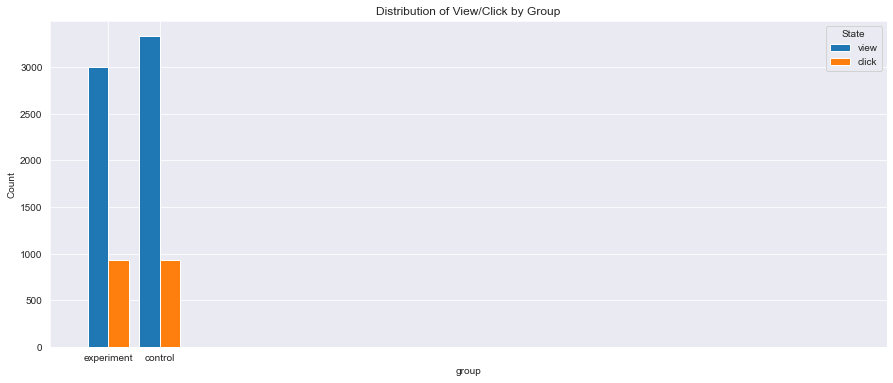

In [9]:
click = df.loc[df["action"] == "click", "group"]
view = df.loc[df["action"] == "view", "group"]

fig, ax = plt.subplots(figsize=(15, 6))

ax.hist(
    x=[view, click],
    label=["view", "click"],
    bins=range(16),
    align="left"
)

ax.set_xlabel("group")
ax.set_ylabel("Count")
ax.set_title("Distribution of View/Click by Group")

ax.legend(title="State");

In [10]:
# converting 'action' to bianary data
df['count']=1
df.head()

,timestamp,id,group,action,count
0,2016-09-24 17:42:27.839496,804196,experiment,view,1
1,2016-09-24 19:19:03.542569,434745,experiment,view,1
2,2016-09-24 19:36:00.944135,507599,experiment,view,1
3,2016-09-24 19:59:02.646620,671993,control,view,1
4,2016-09-24 20:26:14.466886,536734,experiment,view,1


In [11]:
control = df[df.group=='control'].pivot(index='id', columns='action', values='count')
control = control.fillna(value=0)

experiment = df[df.group=='experiment'].pivot(index='id', columns='action', values='count')
experiment = experiment.fillna(value=0)

print("Sample sizes:\tControl: {}\tExperiment: {}".format(len(control), len(experiment)))
print("Total Clicks:\tControl: {}\tExperiment: {}".format(control.click.sum(), experiment.click.sum()))
print("Average click rate:\tControl: {}\tExperiment: {}".format(control.click.mean(), experiment.click.mean()))
control.head()

Sample sizes:	Control: 3332	Experiment: 2996
Total Clicks:	Control: 932.0	Experiment: 928.0
Average click rate:	Control: 0.2797118847539016	Experiment: 0.3097463284379172


action,click,view
id,,
182994,1.0,1.0
183089,0.0,1.0
183248,1.0,1.0
183515,0.0,1.0
183524,0.0,1.0


In [12]:
#Welch's T-test
ttest = stats.ttest_ind(control, experiment, equal_var=False)
p_value = ttest.pvalue/2
p_value

array([0.0044664,       nan])

### Effect size

In [50]:
# effect size
power_analysis = TTestIndPower()
ratio = len(experiment)/len(control)
nobs2 = len(control) * ratio
es = power_analysis.solve_power(alpha=.05, nobs1 = nobs2, \
                               power=.80, alternative='larger')
es

0.06425044939284694

## Verifying Results

One sensible formulation of the data to answer the hypothesis test above would be to create a binary variable representing each individual in the experiment and control group. This binary variable would represent whether or not that individual clicked on the homepage; 1 for they did and 0 if they did not. 

The variance for the number of successes in a sample of a binomial variable with n observations is given by:

## $n\bullet p (1-p)$

Given this, perform 3 steps to verify the results of your statistical test:
1. Calculate the expected number of clicks for the experiment group, if it had the same click-through rate as that of the control group. 
2. Calculate the number of standard deviations that the actual number of clicks was from this estimate. 
3. Finally, calculate a p-value using the normal distribution based on this z-score.

### Step 1:
Calculate the expected number of clicks for the experiment group, if it had the same click-through rate as that of the control group. 

In [19]:
#Your code here
control_mean = control.click.mean()
expected_experiment = control_mean * len(experiment)
expected_experiment 

838.0168067226891

Experiment clicks were 928 vs expected: 838. 

### Step 2:
Calculate the number of standard deviations that the actual number of clicks was from this estimate.

In [24]:
#Your code here
var = len(experiment) * control_mean*(1-control_mean)
std = np.sqrt(var)
std

24.568547907005815

### Step 3: 
Finally, calculate a p-value using the normal distribution based on this z-score.

In [25]:
#Your code here
z_score = (experiment.click.sum() - expected_experiment)/std
z_score

3.6625360854823588

In [26]:
p = 1 - stats.norm.cdf(z_score)
p

0.00012486528006949715

### Analysis:

Does this result roughly match that of the previous statistical test?

> Comment: **Because p=0.0044664(Welch's T-test) and p=0.00012(z-test) < alpha (0.05), we reject H_0 and have evidence to suggest that the experimental homepage is performing better than control one. However, the effect size is 0.064 (very small). **

## Summary

In this lab, you continued to get more practice designing and conducting AB tests. This required additional work preprocessing and formulating the initial problem in a suitable manner. Additionally, you also saw how to verify results, strengthening your knowledge of binomial variables, and reviewing initial statistical concepts of the central limit theorem, standard deviation, z-scores, and their accompanying p-values.